In [1]:
import os

import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.quadrature import get_element, Element
from femsolver.operator import Operator
from femsolver.jax_utils import auto_vmap
import femsolver.sparse as sparse   
import jax.numpy as jnp
import equinox as eqx

from typing import Callable, Optional, Tuple
import sparsejac

# import sparsediffax as sd
import numpy as np

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from femsolver.plotting import STYLE_PATH

### Griffith's critical length

The critical length for plain strain condition is given by:

$$L_\text{G} = 2\mu \Gamma/\pi(1-\nu)\sigma_{\infty}^2$$

where $\mu$ is the shear modulus, $\Gamma$ is the fracture energy, $\nu$ is the
Poisson's ratio, and $\sigma_{\infty}$ is the stress at infinity.

For plain strain condition, the effective Young's modulus is given by:

$$E_\text{eff} = \frac{E}{1-\nu^2}$$

where $E$ is the Young's modulus and $\nu$ is the Poisson's ratio.

For a specimen stretched by a prestrain $\epsilon$, the applied stress at
infinity is given by:

$$\sigma_{\infty} = \epsilon /E_\text{eff}$$


In [155]:
prestrain = 0.2
nu = 0.35

E = 106e3  # N/m^2
lmbda = nu * E / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))

Gamma = 15  # J/m^2
sigma_c = 20e3  # N/m^2

print(f"mu: {mu} N/m^2")
print(f"lmbda: {lmbda} N/m^2")

sigma_inf = prestrain * E

L_G = 2 * mu * Gamma / (jnp.pi * (1 - nu) * sigma_inf**2)
print(f"L_G: {L_G} m")

mu: 39259.259259259255 N/m^2
lmbda: 91604.93827160491 N/m^2
L_G: 0.0012833006216085739 m


In [156]:
def generate_mesh_with_line_elements(
    nx: int,
    ny: int,
    lxs: Tuple[float, float],
    lys: Tuple[float, float],
    curve_func: Optional[Callable[[jnp.ndarray, float], bool]] = None,
    tol: float = 1e-6,
) -> Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray]]:
    """
    Generates a 2D triangular mesh for a rectangle and optionally extracts
    1D line elements along a specified curve.

    Args:
        nx: Number of elements along the x-direction.
        ny: Number of elements along the y-direction.
        lxs: Tuple of the x-coordinates of the left and right edges of the rectangle.
        lys: Tuple of the y-coordinates of the bottom and top edges of the rectangle.
        curve_func: An optional callable that takes a coordinate array [x, y] and
                    a tolerance, returning True if the point is on the curve.
        tol: Tolerance for floating-point comparisons.

    Returns:
        A tuple containing:
        - coords (jnp.ndarray): Nodal coordinates, shape (num_nodes, 2).
        - elements_2d (jnp.ndarray): 2D triangular element connectivity.
        - elements_1d (jnp.ndarray | None): 1D line element connectivity, or None.
    """

    x = jnp.linspace(lxs[0], lxs[1], nx + 1)
    y = jnp.linspace(lys[0], lys[1], ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements_2d = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements_2d.append([n0, n1, n3])
            elements_2d.append([n0, n3, n2])
    elements_2d = jnp.array(elements_2d)

    # --- 2. Extract 1D elements if a curve function is provided ---
    if curve_func is None:
        return coords, elements_2d, None

    # Efficiently find all nodes on the curve using jax.vmap
    on_curve_mask = jax.vmap(lambda c: curve_func(c, tol))(coords)

    elements_1d = []
    # Iterate through all 2D elements to find edges on the curve
    for tri in elements_2d:
        # Define the three edges of the triangle
        edges = [(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])]
        for n_a, n_b in edges:
            # If both nodes of an edge are on the curve, add it to the set
            if on_curve_mask[n_a] and on_curve_mask[n_b]:
                # Sort to store canonical representation, e.g., (1, 2) not (2, 1)
                elements_1d.append(tuple(sorted((n_a, n_b))))

    if not elements_1d:
        return coords, elements_2d, jnp.array([], dtype=int)

    return coords, elements_2d, jnp.unique(jnp.array(elements_1d), axis=0)

Generated 121 nodes.
Generated 200 2D triangular elements.
Found 10 1D line elements on the curve.


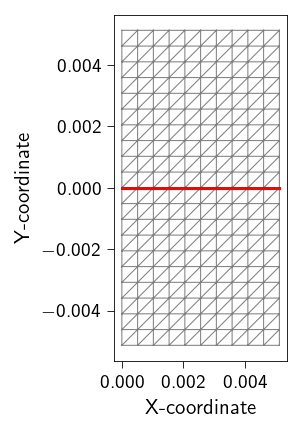

In [351]:
Nx = 10  # Number of elements in X
Ny = 10  # Number of elements in Y
Lx = 4 * L_G  # Length in X
Ly = 4 * L_G  # Length in Y


crack_length = -1.0* L_G


# function identifies nodes on the cohesive line at y = 0. and x > 2.0
def cohesive_line(coord: jnp.ndarray, tol: float) -> bool:
    return jnp.logical_and(
        jnp.isclose(coord[1], 0.0, atol=tol), coord[0] > crack_length
    )


upper_coords, upper_elements_2d, upper_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(0, Ly), curve_func=cohesive_line
)


lower_coords, lower_elements_2d, lower_elements_1d = generate_mesh_with_line_elements(
    nx=Nx, ny=Ny, lxs=(0, Lx), lys=(-Ly, -1e-6), curve_func=cohesive_line
)

coords = jnp.vstack((upper_coords, lower_coords))
elements = jnp.vstack((upper_elements_2d, lower_elements_2d + upper_coords.shape[0]))
lower_elements_1d = lower_elements_1d + upper_coords.shape[0]

print(f"Generated {upper_coords.shape[0]} nodes.")
print(f"Generated {upper_elements_2d.shape[0]} 2D triangular elements.")
print(f"Found {upper_elements_1d.shape[0]} 1D line elements on the curve.")

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)


# Highlight the extracted 1D elements in red
for edge in upper_elements_1d:
    ax.plot(upper_coords[edge, 0], upper_coords[edge, 1], "r-", lw=1.5)
for edge in lower_elements_1d:
    ax.plot(lower_coords[edge, 0], lower_coords[edge, 1], "r-", lw=1.5)

ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect("equal")
plt.show()

To check that the elements along the cohesive line are in same order on both
surface, we compare the node values for the two.


In [352]:
jnp.allclose(coords[upper_elements_1d], coords[lower_elements_1d], atol=1e-6)

Array(True, dtype=bool)

In [353]:
# --- Mesh ---
n_nodes = upper_coords.shape[0]
n_nodes += lower_coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes

We define a function to compute the linear elastic energy density based on the
displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x)
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$

The elastic strain energy density is then given by:

$$
\Psi_{elastic}(u) = \int_{\Omega} \Psi(x) dV
$$


In [354]:
class Material(eqx.Module):
    mu: eqx.AbstractVar[float]
    lmbda: eqx.AbstractVar[float]

In [355]:
# --- Material model (linear elasticity: plane strain) ---
@auto_vmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)


@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@auto_vmap(grad_u=2, mu=0, lmbda=0)
def linear_elasticity_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)

The femsolver provides a generic class `FemOperator` that can be used to solve
FEM problems. This operator is the core of the library as it provide functions
that can automatically integrate the energy density function defined above over
the range of elements.

It takes three arguments:

- `compute_quads`: a function that returns the quadrature points and weights for
  the elements
- `compute_shape_fn`: a function that returns the shape functions for the
  elements
- `compute_energy`: a function that returns the energy density for the elements


In [356]:
class ElasticityOperator(Operator, Material):
    element: Element
    mu: float
    lmbda: float

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(xi, nodal_values, nodes)
        value = linear_elasticity_energy(u_grad, self.mu, self.lmbda)
        return wi * value * detJ

In [357]:
tri3 = get_element("tri3")
elasticity_op = ElasticityOperator(element=tri3, mu=mu, lmbda=lmbda)

In the above definition of the `FemOperator` class, we have used the `quad_tri3`
and `shape_fn_tri3` functions to compute the quadrature points and shape
functions for the triangular elements.

One can simply replace these two functions with any other quadrature and shape
function. Just look at the `quad_tri3` and `shape_fn_tri3` functions in
`femsolver/quadrature.py` to see how to define your own.

For more complex problems, one can define their own implementation of the
`FemOperator` class. One just have to inherit from the `FemOperator` class and
override the functions that are needed.


Now we prepare the mesh and the boundary conditions and solve the linear
elasticity problem.


The total potential energy $\Psi$ is the sum of the elastic strain energy
$\Psi_{elastic}$ and the cohesive energy $\Psi_{cohesive}$.

$$\Psi(u)=\Psi_{elastic}(u)+\Psi_{cohesive}(u)$$

The cohesive energy is defined as:

$$\Psi_{cohesive}(u)= \int_{\Gamma_\text{coh}} \psi(\delta(\boldsymbol{u})) dA$$

where

- $\Gamma_{coh}$ is the cohesive interface.

- $\boldsymbol{\delta}(\boldsymbol{u}) = \boldsymbol{u}^+ - \boldsymbol{u}^-$ is
  the displacement jump across the interface.

- $\psi(\boldsymbol{\delta})$ is the cohesive potential, which defines the
  energy-separation relationship.


In [379]:
@eqx.filter_jit
def compute_opening(jump_quad: jnp.ndarray, nodes: jnp.ndarray) -> float:
    #jax.debug.print("jump_quad: {}", jump_quad)
    opening = jump_quad[1] #jnp.sqrt(jump_quad[0]**2 + jump_quad[1]**2)
    #jax.debug.print("opening: {}", opening)
    return opening


@jax.jit
def exponential_cohesive_energy(
    delta: float,
    interface_props: dict[str, float],
    delta_threshold: float = -1e-14,
) -> float:
    delta_c = (interface_props["Gamma"] * jnp.exp(-1)) / interface_props["sigma_c"]

    def true_fun(delta):
        return interface_props["Gamma"] * (
            1 - (1 + (delta / delta_c)) * (jnp.exp(-delta / delta_c))
        )

    def false_fun(delta):
        return 0.5 * interface_props["penalty"] * delta**2

    return jax.lax.cond(delta > delta_threshold, true_fun, false_fun, delta)


class CohesiveProperties(eqx.Module):
    interface_props: eqx.AbstractVar[dict[str, float]]


class CohesiveOperator(Operator, CohesiveProperties):
    element: Element
    interface_props: dict[str, float]

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes) -> float:
        """
        Compute the cohesive energy.
        """
        jump_quad, jump_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        opening_quad = compute_opening(jump_quad, nodes)
        energy = exponential_cohesive_energy(opening_quad, self.interface_props)
        return wi * energy * detJ

We define a new `Line` element to integrate the cohesive energy. The `Line`
element is a 1D element that is used to integrate the cohesive energy across the
cohesive interface.


In [380]:
line2 = get_element("line2")
interface_op = CohesiveOperator(
    element=line2, interface_props={"Gamma": Gamma, "sigma_c": sigma_c, "penalty": 0.0}
)

Finally, we can put everything together to compute the total energy.


In [381]:
def _total_energy(
    u_flat: jnp.ndarray,
    coords: jnp.ndarray,
    elements: jnp.ndarray,
    elasticity_operator: Operator,
    cohesive_operator: Operator,
    upper_elements: jnp.ndarray,
    lower_elements: jnp.ndarray,
) -> jnp.ndarray:
    """
    Compute the total energy for a given displacement field.
    Args:
        u_flat: Flattened displacement field.
        coords: Coordinates of the nodes.
        elements: Element indices.
        elasticity_operator: ElasticityOperator object.
        cohesive_operator: CohesiveOperator object.
        upper_elements: Indices of the nodes on the upper cohesive surface.
        lower_elements: Indices of the nodes on the lower cohesive surface.
    Returns:
        Total energy.
    """
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    elastic_energy = jnp.sum(elasticity_operator.integrate(u_cell, x_cell))

    u_upper = u[upper_elements]
    u_lower = u[lower_elements]

    # we compute the jump in the displacement field across the cohesive interface
    jump_values = u_upper - u_lower

    # since the two interfaces are identical, we can use the coordinates of the upper interface
    # to intergate and compute the fracture energy
    x_upper_cell = coords[upper_elements]

    fracture_energy = jnp.sum(cohesive_operator.integrate(jump_values, x_upper_cell))

    return elastic_energy + fracture_energy

Since in this example, the elements along the cohesive interface (or in the two
domains) are pre-determined and the position of the nodes (reference frame)
remains the same throughout the simulation, we can use the `eqx.Partial`
function to create a partial function that only depends on the displacement
field.


In [384]:
total_energy = eqx.filter_jit(
    eqx.Partial(
        _total_energy,
        coords=coords,
        elements=elements,
        elasticity_operator=elasticity_op,
        cohesive_operator=interface_op,
        upper_elements=upper_elements_1d,
        lower_elements=lower_elements_1d,
    )
)

In [385]:
total_energy(jnp.ones(n_dofs))

Array(0., dtype=float64)

## Sparsity pattern

We will solve this problem using a sparse matrix solver. This is a good idea because the matrix is very sparse. In order to do this, we need to create a sparsity pattern. The sparsity pattern is a list of the non-zero elements in the matrix. In FEM, the sparsity pattern is based on the connectivity of the elements and the degrees of freedom per node. 

For cohesive elements, the sparsity pattern is different from the standard FEM elements. In this case, the sparsity pattern is based on the connectivity of the cohesive elements and the degrees of freedom per node. Since the cohesive elements are not connected to the standard FEM elements, we need to create a separate sparsity pattern for the cohesive elements. 

The cohesive element are actually pseudo elements as they do not exists but they connect the 4 nodes of the line elements at the upper and lower interface (for 2D problems).

In [386]:
@auto_vmap(lower_element=1, upper_element=1)
def create_cohesive_elements(lower_element, upper_element):
    return jnp.array([lower_element[0], lower_element[1], upper_element[1], upper_element[0]])


cohesive_elements = create_cohesive_elements(lower_elements_1d, upper_elements_1d)

In `femsolver`, we use the `sparse` module to create a sparsity pattern for the matrix. The function  takes the following arguments:

- `elements`: The connectivity of each element in the mesh.
- `n_dofs_per_node`: The number of degrees of freedom per node.
- `K_shape`: The shape of the matrix K.
- `constraint_elements`: The connectivity of the constraint elements in the mesh.

The function returns a `jax.experimental.sparse.BCOO` object.

The `BCOO` object is a sparse matrix in compressed block-column format. It is a good format for sparse matrices because it is efficient for arithmetic operations and has a small memory footprint.

In [387]:
sparsity_pattern = sparse.create_sparsity_pattern(
    elements, n_dofs_per_node, (n_dofs, n_dofs), cohesive_elements
)

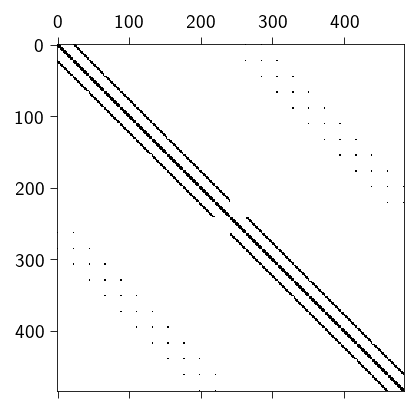

In [388]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(3,3))
plt.spy(sparsity_pattern.todense())
plt.show()

We can now use this sparsity pattern to create a sparse Jacobian of the gradient of the total energy. We can use the `sparsejac` module to create the Jacobian. This allows us to only compute the entries of the Jacobian that are non-zero. This is a good way to save memory and time.

In [389]:
# creating functions to compute the gradient and
# Hessian of the total energy using jax
gradient = jax.jacrev(total_energy)
hessian_sparse = sparsejac.jacfwd(gradient, sparsity=sparsity_pattern)

We now locate the dofs in the two domains to apply boundary conditions.


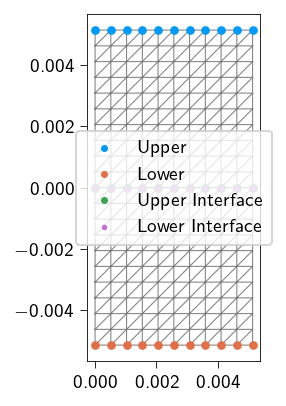

In [390]:
# --- Apply Dirichlet BCs ---
y_max = jnp.max(coords[:, 1])
y_min = jnp.min(coords[:, 1])

y_min_upper_body = jnp.min(upper_coords[:, 1])
y_max_lower_body = jnp.max(lower_coords[:, 1])

upper_nodes = jnp.where(jnp.isclose(coords[:, 1], y_max))[0]
lower_nodes = jnp.where(jnp.isclose(coords[:, 1], y_min))[0]
upper_interface_nodes = jnp.where(
    jnp.isclose(coords[:, 1], y_min_upper_body) & (coords[:, 0] > crack_length)
)[0]
lower_interface_nodes = jnp.where(
    jnp.isclose(coords[:, 1], y_max_lower_body) & (coords[:, 0] > crack_length)
)[0]


fixed_dofs = jnp.concatenate(
    [
        2 * upper_nodes,
        2 * upper_nodes + 1,
        2 * lower_nodes,
        2 * lower_nodes + 1,
    ]
)

cohesive_dofs = jnp.concatenate(
    [
        2 * upper_interface_nodes,
        2 * upper_interface_nodes + 1,
        2 * lower_interface_nodes,
        2 * lower_interface_nodes + 1,
    ]
)


applied_disp = prestrain * Ly

prescribed_values = jnp.zeros(n_dofs).at[2 * upper_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * upper_nodes + 1].set(applied_disp / 2.0)
prescribed_values = prescribed_values.at[2 * lower_nodes].set(0.0)
prescribed_values = prescribed_values.at[2 * lower_nodes + 1].set(-applied_disp / 2.0)

free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)


# We plot the mesh the nodes that are fixed on the left and right edges.

plt.style.use(STYLE_PATH)
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.triplot(coords[:, 0], coords[:, 1], elements, color="grey", lw=0.5)

ax.scatter(coords[upper_nodes, 0], coords[upper_nodes, 1], s=10, label="Upper")
ax.scatter(coords[lower_nodes, 0], coords[lower_nodes, 1], s=10, label="Lower")
ax.scatter(
    coords[upper_interface_nodes, 0],
    coords[upper_interface_nodes, 1],
    s=10,
    label="Upper Interface",
)
ax.scatter(
    coords[lower_interface_nodes, 0],
    coords[lower_interface_nodes, 1],
    s=5,
    label="Lower Interface",
)
ax.legend()
ax.set_aspect("equal")
ax.legend(loc="center")
plt.show()

To apply the Dirichlet boundary conditions, we use the lifting approach. This is a constraint approach where the entry of the stiffness matrix corresponding to the constrained degrees of freedom are set to 1 and the corresponding rows and columns are set to 0.

The function `get_bc_indices` takes the following arguments:

- `indices`: The indices of the sparsity pattern.
- `fixed_dofs`: The degrees of freedom that are constrained.

The function returns two arrays:

- `zero_indices`: The indices of the sparsity pattern that correspond to the constrained degrees of freedom.
- `one_indices`: The indices of the sparsity pattern that correspond to the unconstrained degrees of freedom.

In [391]:
zero_indices, one_indices = sparse.get_bc_indices(
    sparsity_pattern.indices, fixed_dofs
)

## Sparse Solver (Using PETSc)

Now, to solve this sparse system, we can use the PETSc library. PETSc is a library for solving sparse linear systems. It is a good choice for large sparse systems because it is efficient and has a good interface. 

We use a Newton-Raphson solver to solve the system. We use the direct linear sparse solver in PETSc to solve the system.


In [392]:
from petsc4py import PETSc
from time import perf_counter

In [409]:
# ------------- Newton-Raphson Solver -------------------
def newton_solver(
    fixed_dofs,
    u_target_flat,
    n_steps,
    tol=1e-8,
    max_iter=20,
):

    du_total = u_target_flat / n_steps  # displacement increment
    u = jnp.zeros(n_nodes * n_dofs_per_node)
    fext = jnp.zeros(n_nodes * n_dofs_per_node)

    A = PETSc.Mat()
    A.createAIJ(size=(n_dofs, n_dofs))

    b = A.createVecLeft()
    du = A.createVecRight()

    errors = []

    for step in range(n_steps):
        print(f"Step {step+1}/{n_steps}")
        u = u.at[fixed_dofs].set((step + 1) * du_total[fixed_dofs])

        fint = gradient(u)
        K_sparse = hessian_sparse(u)

        iiter = 0
        norm_res = 1.0

        while norm_res > tol and iiter < max_iter:
            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            K_sparse_bc = K_sparse.data.at[zero_indices].set(0)
            K_sparse_bc = K_sparse_bc.at[one_indices].set(1)

            A.zeroEntries()
            for index, value in zip(sparsity_pattern.indices, K_sparse_bc):
                row, col = index
                A.setValue(row, col, value)
            A.assemble()

            ksp = PETSc.KSP().create()
            ksp.setOperators(A)

            b.zeroEntries()
            b.setArray(residual)

            ksp.setConvergenceHistory()
            ksp.getPC().setType("none")
            du.zeroEntries()
            ksp.solve(b, du)

            ksp.destroy()

            u = u.at[:].add(du.getArray())

            fint = gradient(u)
            K_sparse = hessian_sparse(u)

            residual = fext - fint
            residual = residual.at[fixed_dofs].set(0)

            norm_res = jnp.linalg.norm(residual)
            #print(f"  Residual: {norm_res:.2e}")

            iiter += 1

        errors.append(norm_res)

    return u, errors

In [410]:
u_static, errors = newton_solver(
    fixed_dofs=fixed_dofs,
    u_target_flat=prescribed_values,
    n_steps=50,
    tol=1e-8,
    max_iter=30,
)

Step 1/50
Step 2/50
Step 3/50
Step 4/50
Step 5/50
Step 6/50
Step 7/50
Step 8/50
Step 9/50
Step 10/50
Step 11/50
Step 12/50
Step 13/50
Step 14/50
Step 15/50
Step 16/50
Step 17/50
Step 18/50
Step 19/50
Step 20/50
Step 21/50
Step 22/50
Step 23/50
Step 24/50
Step 25/50
Step 26/50
Step 27/50
Step 28/50
Step 29/50
Step 30/50
Step 31/50
Step 32/50
Step 33/50
Step 34/50
Step 35/50
Step 36/50
Step 37/50
Step 38/50
Step 39/50
Step 40/50
Step 41/50
Step 42/50
Step 43/50
Step 44/50
Step 45/50
Step 46/50
Step 47/50
Step 48/50
Step 49/50
Step 50/50


Now we prepare some functions to compute the stress and to plot the deformed
shape with the von-mises stress.


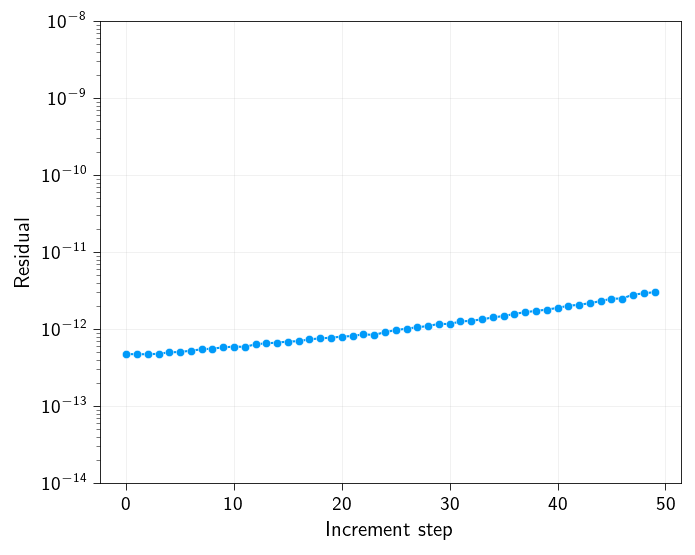

In [414]:
plt.style.use(STYLE_PATH)
plt.figure(figsize=(5, 4))
plt.semilogy(errors, marker="o")
plt.xlabel("Increment step")
plt.ylabel("Residual")
plt.ylim(1e-14, 1e-8)
plt.grid(True)
plt.show()

In [415]:
grad_us = elasticity_op.gradient(
    u_static.reshape(-1, n_dofs_per_node)[elements], coords[elements]
)
strains = compute_strain(grad_us)
stresses = compute_stress(strains, elasticity_op.mu, elasticity_op.lmbda)

In [416]:
# --- Visualization ---
from femsolver.plotting import STYLE_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

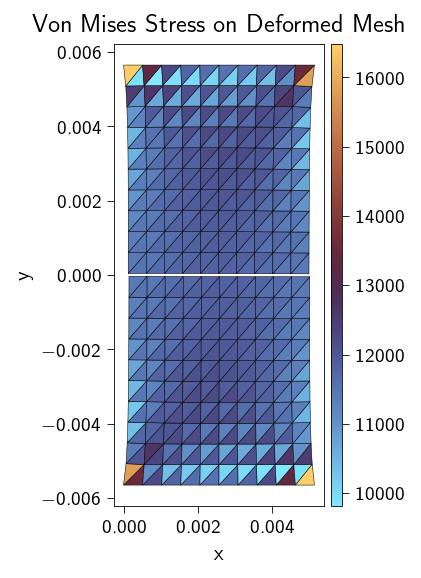

In [417]:
plot_displacement_and_stress(
    coords,
    u_static.reshape(-1, n_dofs_per_node),
    elements,
    stresses[:, :, 1, 1].flatten(),
)

In [418]:
def plot_nodal_values(coords, u, elements, nodal_values, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements

    plt.style.use(STYLE_PATH)
    fig = plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb = ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        nodal_values,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()

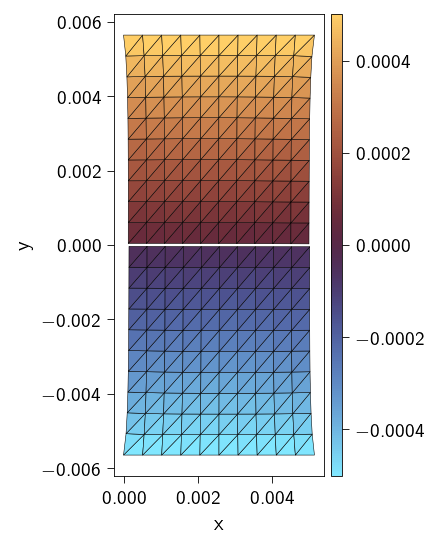

In [419]:
plot_nodal_values(
    coords,
    u_static.reshape(-1, n_dofs_per_node),
    elements,
    nodal_values=u_static.reshape(-1, n_dofs_per_node)[:, 1].flatten(),
)